In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import os
from dotenv import load_dotenv

In [3]:
# получение данных о визитах и регистрациях за период 2023-03-01 - 2023-09-01 по API

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp_registrations = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

visits_data = resp_visits.json()
registrations_data = resp_registrations.json()
visits_df = pd.DataFrame(visits_data)
registrations_df = pd.DataFrame(registrations_data)

#### Расчитать конверсию визитов в регистрации, исключая поисковые и SEO-боты (содержит bot в User-Agent). 

Поля в итоговом датафрейме:

    - date_group — дата
    - platform — платформа: web, ios, android
    - visits — визиты в дату
    - registrations — регистрации в дату
    - conversion — конверсия

In [4]:
# подготовка даных по визитам для расчета конверсии

visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
clean_visits = visits_df[~visits_df['user_agent'].str.contains("bot")]
last_date = clean_visits.groupby('visit_id')['datetime'].max().reset_index()
last_visits = clean_visits.merge(last_date, on=['visit_id', 'datetime'])
last_visits['date_group'] = last_visits['datetime'].dt.date
visits_count = (last_visits
                .groupby(['date_group', 'platform'])
                .agg({'visit_id': 'count'})
                .reset_index()
                .rename(columns={'visit_id': 'visits'})
               )


In [5]:
# подготовка данных по регистрациям для расчета конверсии

registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime'])
registrations_df['date_group'] = registrations_df['datetime'].dt.date
registrations_count = (registrations_df
                       .groupby(['date_group', 'platform'])
                       .agg({'user_id': 'count'})
                       .reset_index()
                       .rename(columns={'user_id': 'registrations'})
                      )


In [9]:
# расчет конверсии визитов в регистрации

visits_conversion = visits_count.merge(registrations_count, on=['date_group', 'platform'])
visits_conversion['conversion'] = visits_conversion['registrations'] / visits_conversion['visits'] * 100


In [153]:
visits_conversion.to_json('./conversion.json')

#### Добавить данные по рекламным кампаниям. 

Поля итогового датафрейма:

    date_group — дата
    visits — визиты в дату
    registrations — регистрации в дату
    cost — затраты на рекламу, 0 если не было затрат
    utm_campaign — название рекламной кампании, none если не было в этот период рекламы

csv файл с данными о рекламе (сохранить в рабочем каталоге проекта):
https://drive.google.com/file/d/12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj/view?usp=sharing

In [6]:
ads_df = pd.read_csv('./ads.csv')

In [10]:
# подготовка датафрейма по рекламным кампаниям

ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date
ads_cost = ads_df[['date_group', 'cost', 'utm_campaign']]
visits_and_registrations = (visits_conversion
                            .groupby('date_group')
                            .agg({'visits': 'sum', 'registrations': 'sum'})
                            .reset_index()
                           )
ads = visits_and_registrations.merge(ads_cost, how='left', on='date_group')
ads['cost'] = ads['cost'].fillna(0)

In [156]:
ads.to_json('./ads.json')

#### Построить следующие графики в формате PNG:

    Итоговые визиты
    Итоговые визиты с разбивкой по платформам: web, android, ios
    Итоговые регистрации
    Итоговые регистрации с разбивкой по платформе: web, android, ios
    Конверсия по каждой платформе
    Средняя конверсия
    Стоимости реклам
    Визиты за весь период с цветовым выделением рекламной кампании
    Регистрации за весь период с цветовым выделением рекламной кампании

Графики сохранить в формате PNG в директорию ./charts

In [157]:
# создание каталога для хранения графиков

chart_path = './charts'
os.makedirs(chart_path, exist_ok=True)

In [11]:
# подготовка данных для графиков по итоговым визитам и регистрациям

total_visits_registrations = ads[['date_group', 'visits', 'registrations']].copy()
total_visits_registrations['date_group'] = pd.to_datetime(total_visits_registrations['date_group'])

# подготовка данных для графиков по итоговым визитам и регистрациям с разбивкой по платформам

pivot_data_visits = visits_conversion.pivot(index='date_group', columns='platform', values='visits')
pivot_data_visits.index = pd.to_datetime(pivot_data_visits.index)

pivot_data_registrations = visits_conversion.pivot(index='date_group', columns='platform', values='registrations')
pivot_data_registrations.index = pd.to_datetime(pivot_data_registrations.index)

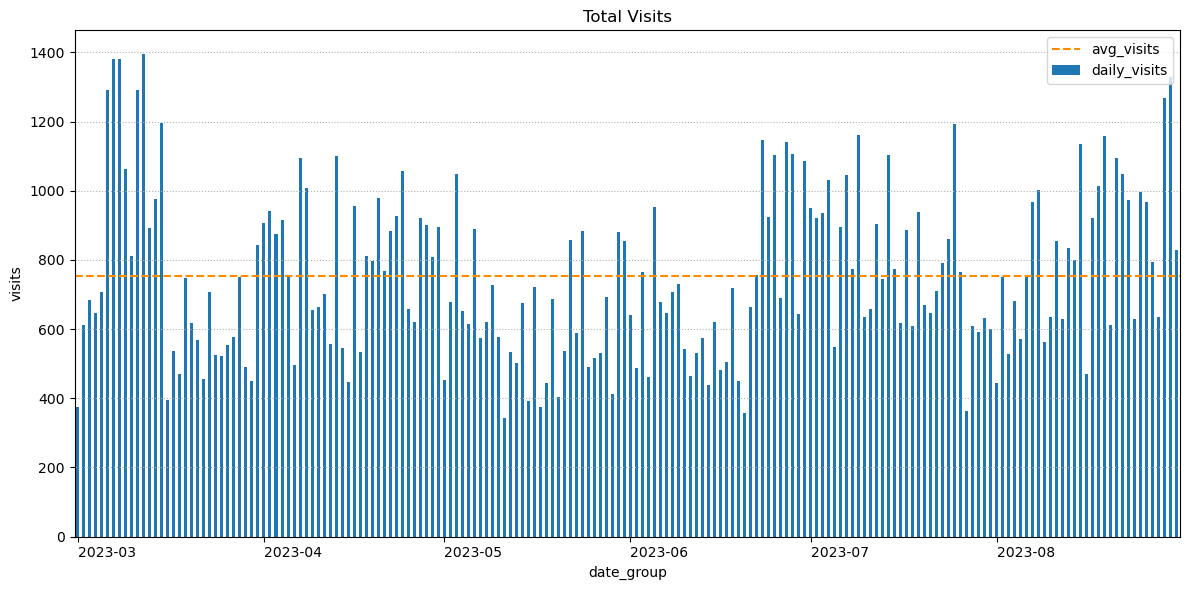

In [12]:
# построение графика итоговых визитов

ax = total_visits_registrations.plot(x='date_group', y='visits', kind='bar', figsize=(12, 6), label='daily_visits')
plt.axhline(total_visits_registrations['visits'].mean(), linestyle='--', color='darkorange', label='avg_visits')

monthly_ticks = total_visits_registrations[total_visits_registrations['date_group'].dt.is_month_start]
monthly_ticks_positions = monthly_ticks.index

ax.set_xticks(monthly_ticks_positions)
ax.set_xticklabels(monthly_ticks['date_group'].dt.strftime('%Y-%m'), rotation=0, ha='left')

plt.title('Total Visits')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.grid(axis='y', linestyle=':')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./charts/total_visits.png')

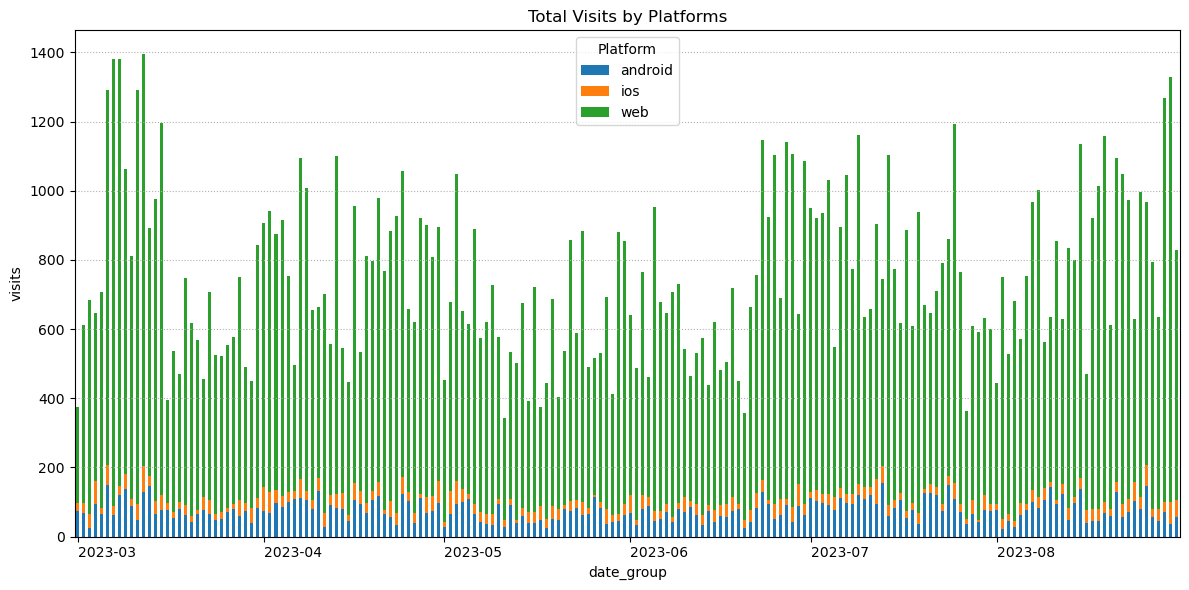

In [13]:
# построение графика итоговых визитов с разбивкой по платформам

ax = pivot_data_visits.plot(kind='bar', stacked=True, figsize=(12, 6))

monthly_ticks = pivot_data_visits.index[pivot_data_visits.index.day == 1]  # Только первые дни месяца
monthly_tick_positions = [pivot_data_visits.index.get_loc(date) for date in monthly_ticks]

ax.set_xticks(monthly_tick_positions)
ax.set_xticklabels(monthly_ticks.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(axis='y', linestyle=':', zorder=0)
plt.title('Total Visits by Platforms')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.legend(title='Platform', loc='best')
plt.tight_layout()
plt.savefig('./charts/total_visits_by_platform.png')

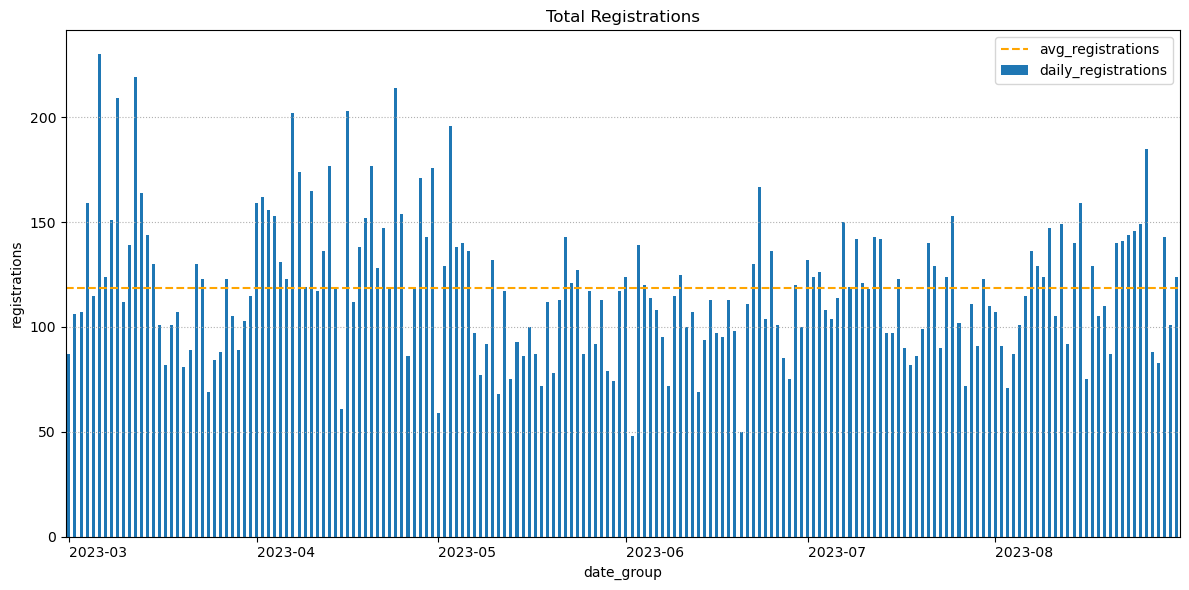

In [14]:
# построение графика итоговых регистраций

ax = total_visits_registrations.plot(x='date_group', y='registrations', kind='bar', figsize=(12, 6), label='daily_registrations')
plt.axhline(total_visits_registrations['registrations'].mean(), linestyle='--', color='orange', label='avg_registrations')

monthly_ticks = total_visits_registrations[total_visits_registrations['date_group'].dt.is_month_start]
monthly_ticks_positions = monthly_ticks.index

ax.set_xticks(monthly_ticks_positions)
ax.set_xticklabels(monthly_ticks['date_group'].dt.strftime('%Y-%m'), rotation=0, ha='left')

plt.title('Total Registrations')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.grid(axis='y', linestyle=':')
plt.legend()
plt.tight_layout()
plt.savefig('./charts/total_registrations.png')

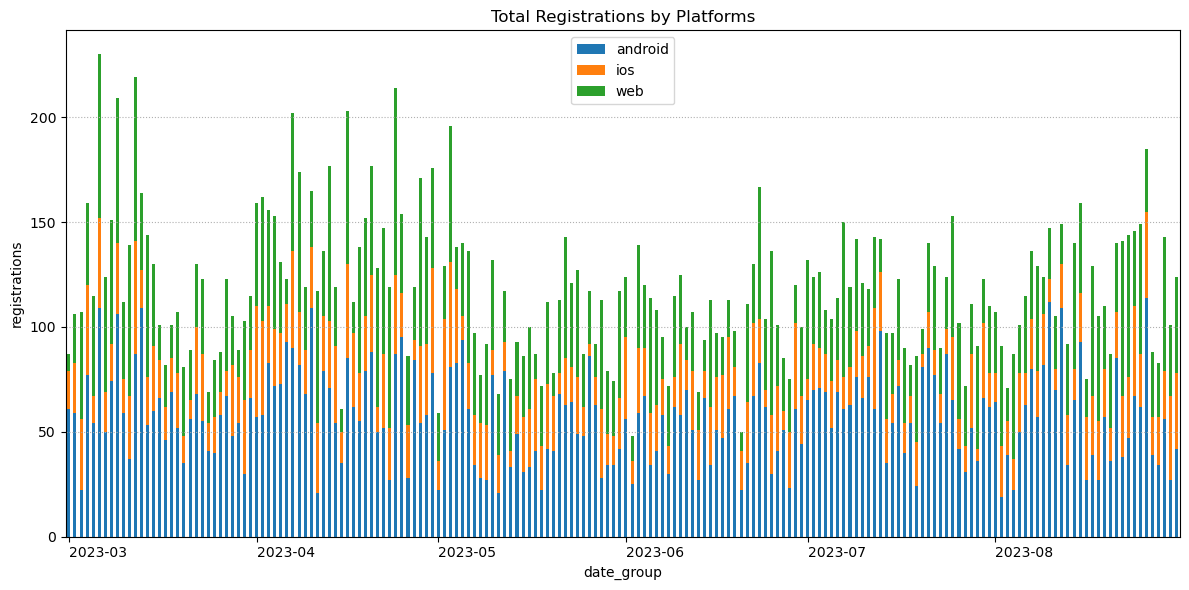

In [15]:
# построение графика итоговых регистраций с разбивкой по платформам

ax = pivot_data_registrations.plot(kind='bar', stacked=True, figsize=(12, 6))

monthly_ticks = pivot_data_registrations.index[pivot_data_registrations.index.day == 1]
monthly_tick_positions = [pivot_data_registrations.index.get_loc(date) for date in monthly_ticks]

ax.set_xticks(monthly_tick_positions)
ax.set_xticklabels(monthly_ticks.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(axis='y', linestyle=':')
plt.title('Total Registrations by Platforms')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('./charts/total_registrations_by_platform.png')

In [16]:
# подготовка данных для графиков конверсий по каждой платформе

platforms_conversion = visits_conversion[['date_group', 'platform', 'conversion']].copy()


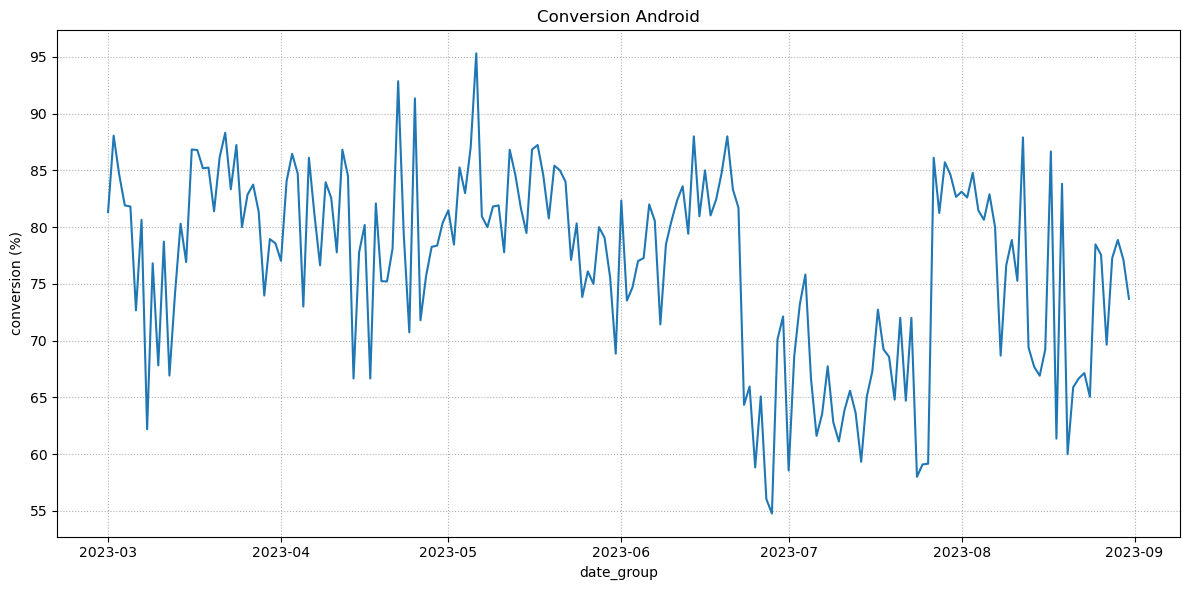

In [17]:
# построение графика конверсии для Android

andriod_conversion = platforms_conversion.query('platform == "android"')

andriod_conversion.plot(x='date_group', y='conversion', kind='line', figsize=(12, 6), legend=False)

plt.title('Conversion Android')
plt.xlabel('date_group')
plt.ylabel('conversion (%)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_android.png')

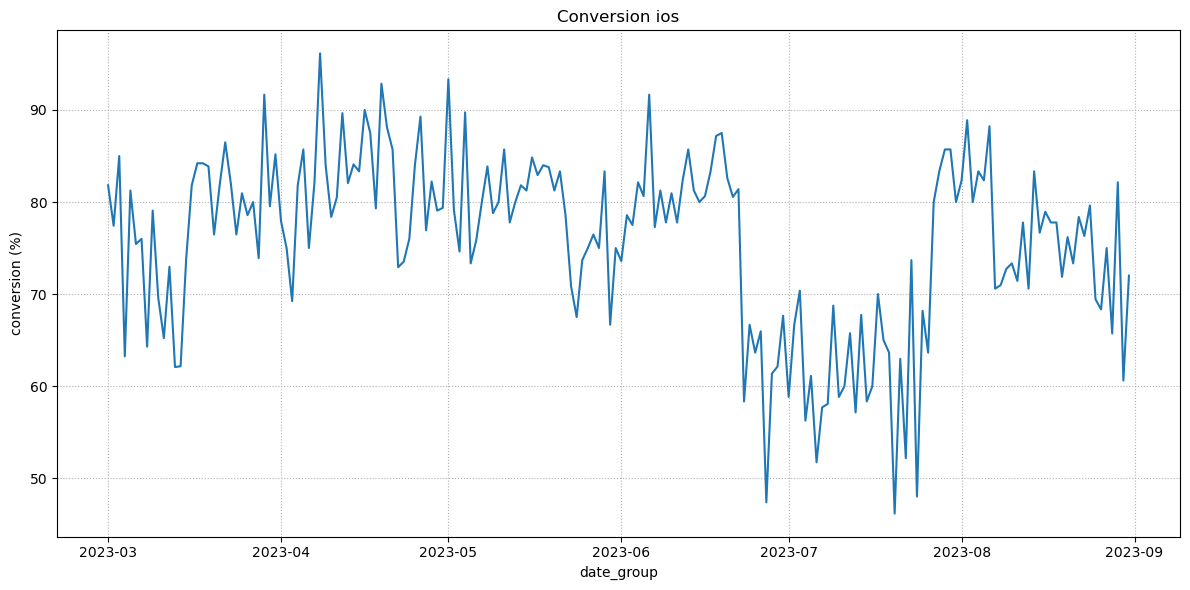

In [18]:
# построение графика конверсии для iOS

ios_conversion = platforms_conversion.query('platform == "ios"')

ios_conversion.plot(x='date_group', y='conversion', kind='line', figsize=(12, 6), legend=False)

plt.title('Conversion ios')
plt.xlabel('date_group')
plt.ylabel('conversion (%)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_ios.png')

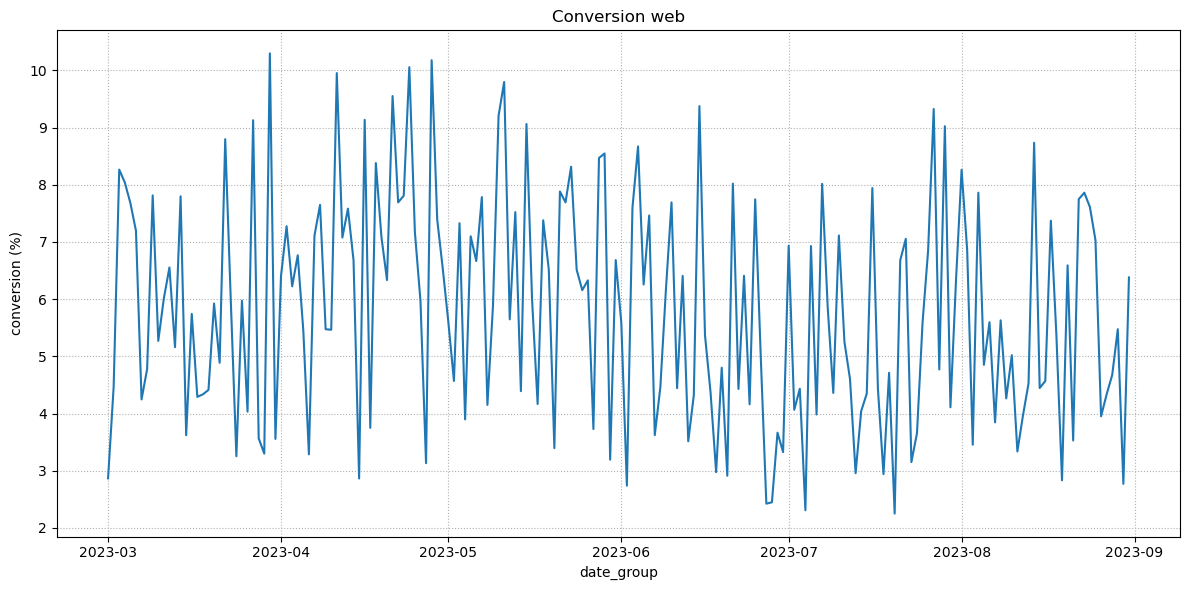

In [19]:
# построение графика конверсии для web

web_conversion = platforms_conversion.query('platform == "web"')

web_conversion.plot(x='date_group', y='conversion', kind='line', figsize=(12, 6), legend=False)

plt.title('Conversion web')
plt.xlabel('date_group')
plt.ylabel('conversion (%)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.savefig('./charts/conversion_web.png')

In [20]:
# подготовка данных для графика средней конверсии

overall_conversion = ads[['date_group', 'visits', 'registrations']].copy()
overall_conversion['conversion'] = (overall_conversion['registrations'] / overall_conversion['visits']*100).round(2)

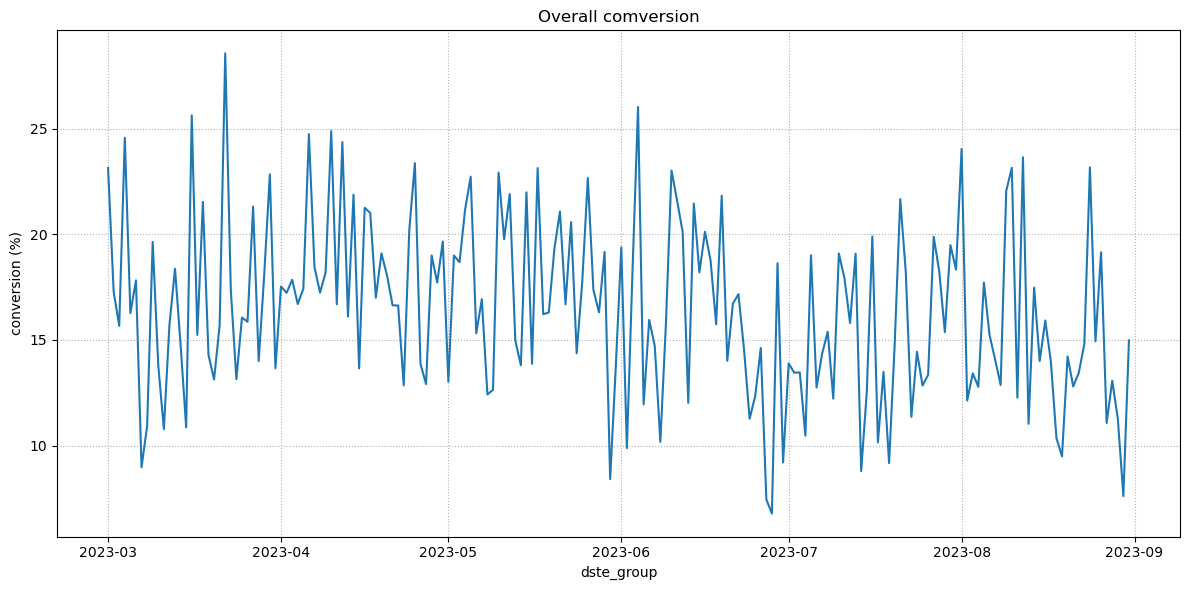

In [21]:
# построение графика средней конверсии

overall_conversion.plot(x='date_group', y='conversion', kind='line', figsize=(12, 6), legend=False)

plt.title('Overall comversion')
plt.xlabel('dste_group')
plt.ylabel('conversion (%)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')

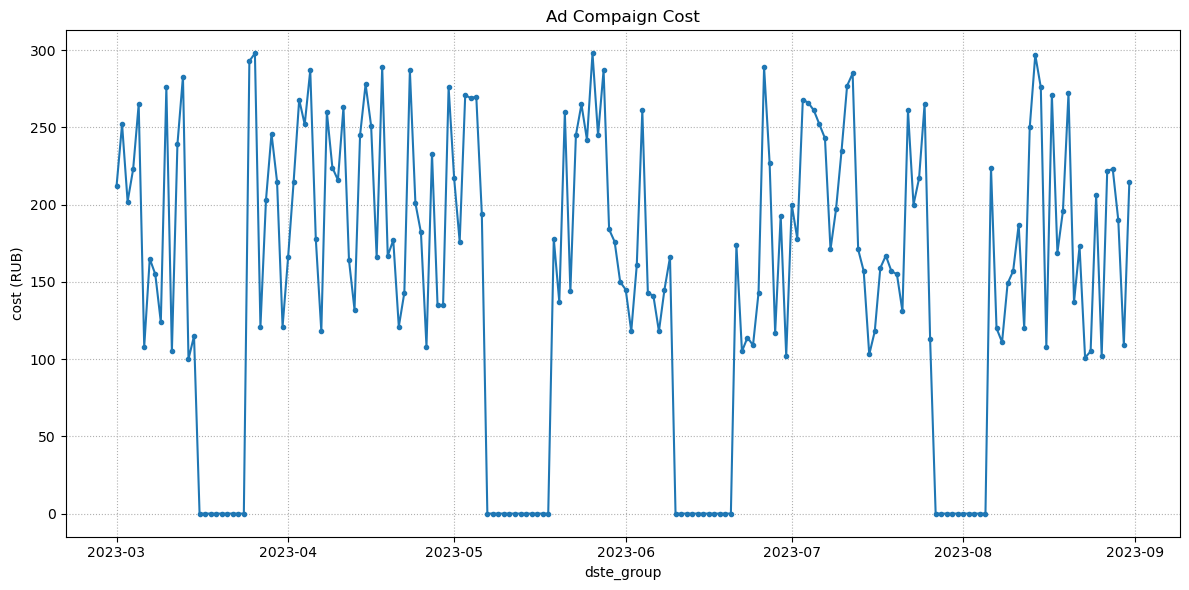

In [27]:
# построение графика стоимости рекламы

ads.plot(x='date_group', y='cost', kind='line', figsize=(12, 6), legend=False, marker='o', markersize=3)

plt.title('Ad Compaign Cost')
plt.xlabel('dste_group')
plt.ylabel('cost (RUB)')
plt.grid(linestyle=':')
plt.tight_layout()
plt.savefig('./charts/ad_cost.png')

In [23]:
# подготовка данных для графиков итоговых визитов и регистраций с выделением цветом периодов рекламы

visits_marketing = ads.copy()
visits_marketing['date_group'] = pd.to_datetime(visits_marketing['date_group'])

visits_marketing['campaigns_n'] = (visits_marketing['utm_campaign'] != visits_marketing['utm_campaign'].shift()).cumsum()
campaign_periods = (visits_marketing
                   .dropna(subset=['utm_campaign'])
                   .groupby(['campaigns_n','utm_campaign'])
                   .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                   .reset_index()
                   )

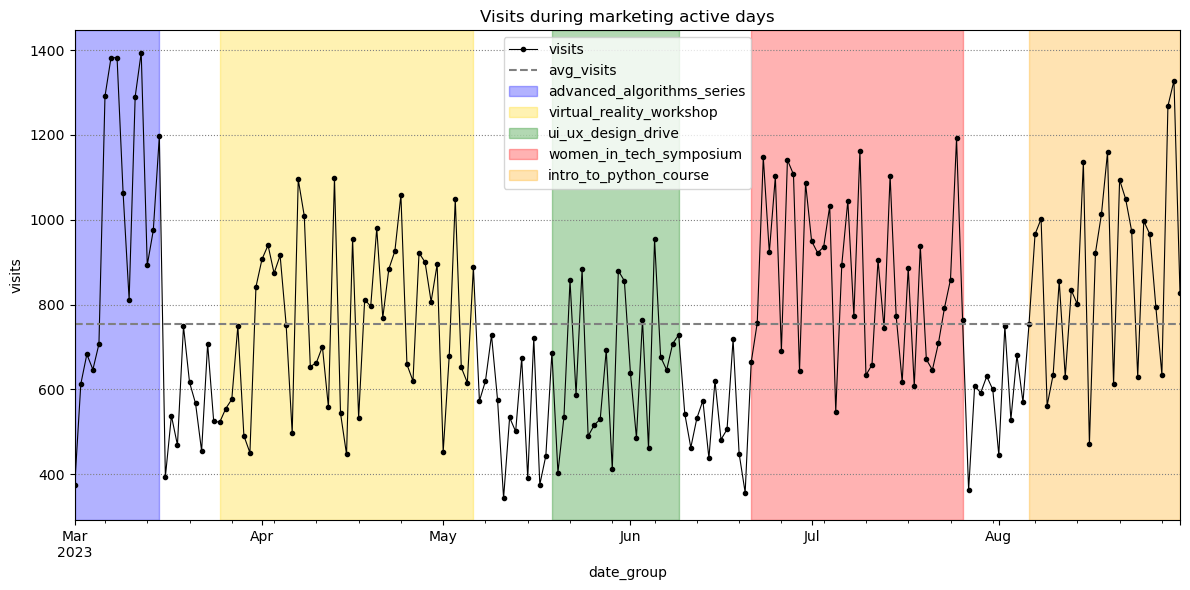

In [24]:
# построение графика итоговых визитов с цветовым выделением рекламных кампаний

visits_marketing.plot(x='date_group', y='visits', kind='line', figsize=(12, 6), 
                      linewidth=0.8, color='black', label='visits', marker='o', markersize=3)
plt.axhline(visits_marketing['visits'].mean(), linestyle='--', color='gray', label='avg_visits')

colors = ['blue', 'gold', 'green', 'red', 'orange']
for i, row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])


plt.grid(axis='y', linestyle=':', color='grey')
plt.legend(loc='best')
plt.title('Visits during marketing active days')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.tight_layout()
plt.savefig('./charts/visits_during_campaigns.png')

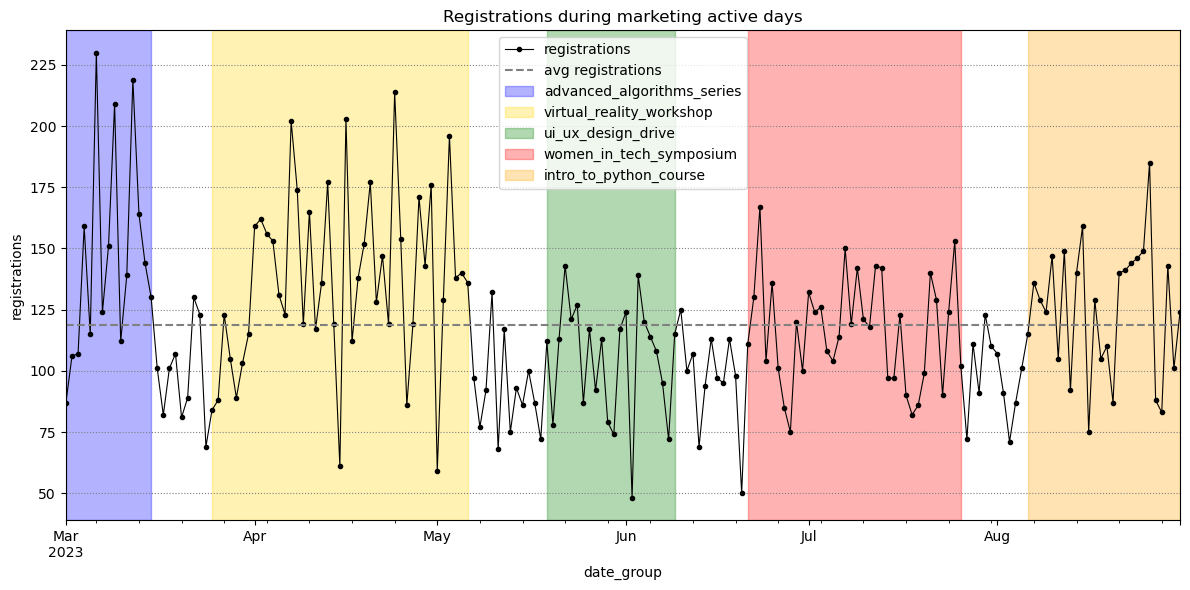

In [25]:
# построение графика итоговых регистраций с цветовым выделением рекламных кампаний

visits_marketing.plot(x='date_group', y='registrations', kind='line', figsize=(12, 6),
                     linewidth=0.8, color='black', marker='o', markersize=3, label='registrations')
plt.axhline(visits_marketing['registrations'].mean(), linestyle='--', color='grey', label='avg registrations')

colors = ['blue', 'gold', 'green', 'red', 'orange']
for i, row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])


plt.grid(axis='y', linestyle=':', color='grey')
plt.legend(loc='best')
plt.title('Registrations during marketing active days')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.tight_layout()
plt.savefig('./charts/registrations_during_campaigns.png')

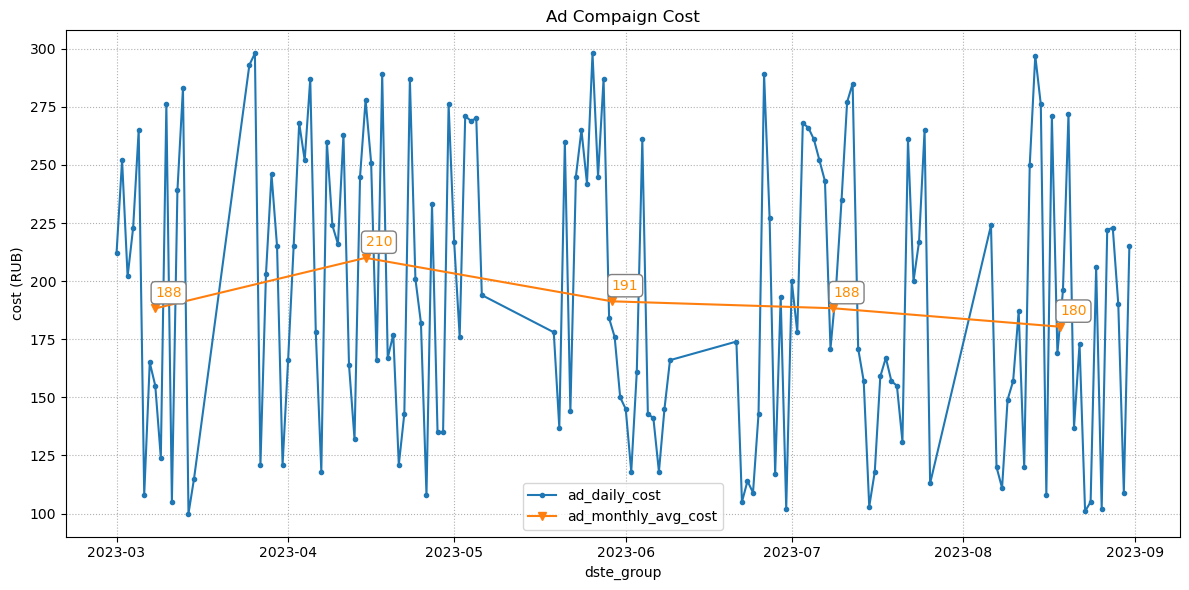

In [60]:
# вторая версия графика стоимости рекламы

ads_cost = ads.query('cost > 0').copy()
ads_cost['date_group'] = pd.to_datetime(ads_cost['date_group'])
ads_monthly_cost = (ads_cost
                    .groupby('utm_campaign')
                    .agg({'cost': 'mean', 'date_group': 'mean'})
                    .reset_index()
                    .sort_values(by='date_group')
                   )

plt.figure(figsize=(12, 6))

plt.plot(ads_cost['date_group'], ads_cost['cost'], marker='o', markersize=3, label='ad_daily_cost')
plt.plot(ads_monthly_cost['date_group'], ads_monthly_cost['cost'], marker='v', label='ad_monthly_avg_cost')

for _, row in ads_monthly_cost.iterrows():
    plt.text(row['date_group'], row['cost'] + 5, f"{int(row['cost'])}", color='darkorange',
             bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
            )

plt.title('Ad Compaign Cost')
plt.xlabel('dste_group')
plt.ylabel('cost (RUB)')
plt.grid(linestyle=':')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./charts/ad_cost2.png')